# LC Wrapper E2E Test - Basic Functionality on JupyterLab

- Test that LC Wrapper kernel works properly
- Verify that log files are created
- Verify that metadata is recorded in cells
- Test summarize mode with `!!` command

In [134]:
jupyterlab_url = "http://localhost:8888/lab?token=test-token"
default_result_path = None
close_on_fail = False
transition_timeout = 10000
default_delay = 200
browser_type = "chromium"
jupyter_work_dir = '../artifacts/jupyter-work'

In [135]:
import tempfile

work_dir = tempfile.mkdtemp()
if default_result_path is None:
    default_result_path = work_dir
work_dir

'/var/folders/m0/myy2ys0s3cl_73__2gw8fw140000gn/T/tmpi06seiz3'

In [136]:
import re
import asyncio
import importlib

import scripts.playwright
importlib.reload(scripts.playwright)

from scripts.playwright import *

import scripts.lc_wrapper as lc_wrapper
importlib.reload(lc_wrapper)

await init_pw_context(close_on_fail=close_on_fail, last_path=default_result_path, delay=default_delay, browser_type=browser_type)

('20251111-093935',
 '/var/folders/m0/myy2ys0s3cl_73__2gw8fw140000gn/T/tmpk1dd_hhp')

## Open JupyterLab and wait for it to load

Start epoch: 1762821575.7296 seconds


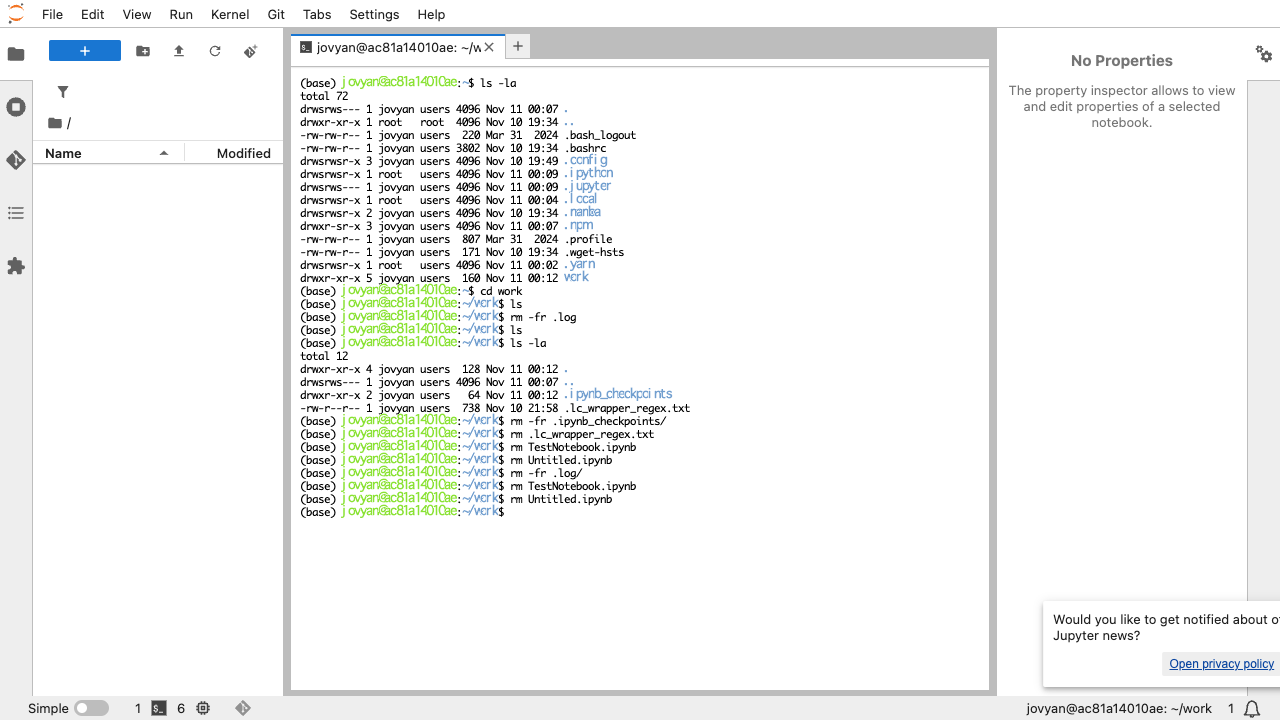

In [137]:
lab_page = None

async def _step(page):
    await page.goto(jupyterlab_url)

    # Wait for JupyterLab to load
    await expect(page.locator('#jp-main-dock-panel')).to_be_visible(timeout=transition_timeout)

    # Wait for file browser to be visible
    await expect(page.locator('.jp-DirListing')).to_be_visible(timeout=transition_timeout)

    global lab_page
    lab_page = page

await run_pw(_step)

## Remove existing test notebook if it exists

Start epoch: 1762821577.3289118 seconds


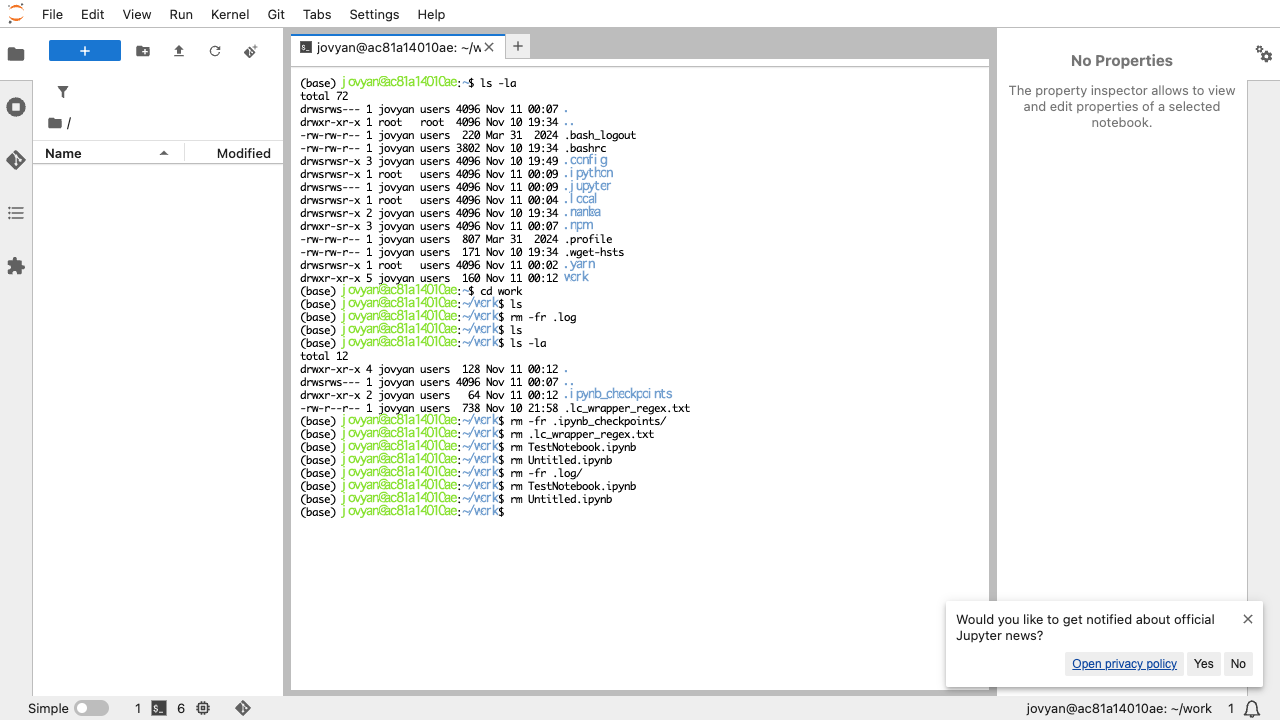

In [138]:
import scripts.lc_wrapper
importlib.reload(scripts.lc_wrapper)

test_filename = 'TestNotebook.ipynb'

async def _step(page):
    await asyncio.sleep(3)  # Wait for file browser to stabilize
    test_filename_locator = lc_wrapper.get_file_browser_item_locator(page, test_filename)
    
    if not await test_filename_locator.is_visible():
        print(f"Test notebook '{test_filename}' does not exist. Creating a new one.")
        return
    
    await test_filename_locator.click(button='right')
    await page.locator('//*[@data-command="filebrowser:delete"]').click()

    await page.locator('//*[contains(@class, "jp-Dialog-buttonLabel") and text()="Delete"]').click()

    await expect(test_filename_locator).not_to_be_visible(timeout=transition_timeout)

await run_pw(_step)

## Create a new notebook with LC_wrapper kernel

Start epoch: 1762821580.904767 seconds
Created notebook panel: id-184d6d65-a23c-4e6d-a143-16118be1e612


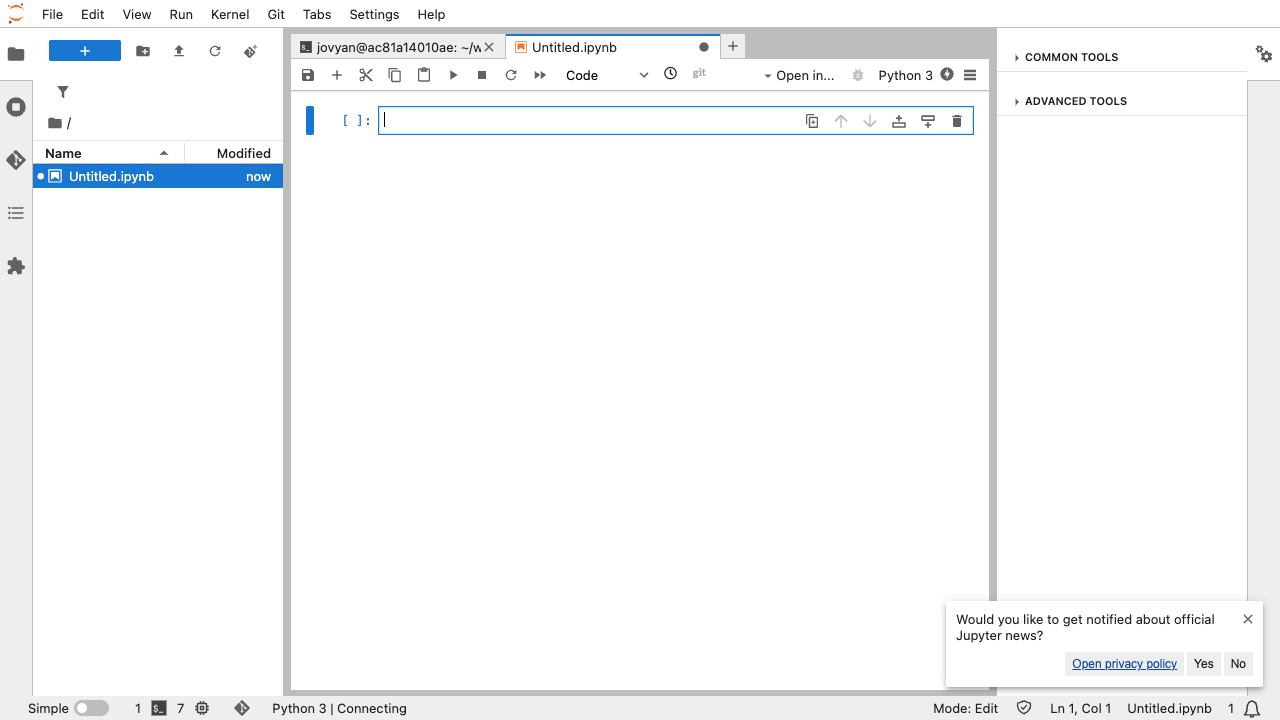

In [139]:
import scripts.lc_wrapper as lc_wrapper
importlib.reload(lc_wrapper)

created_panel_id = None

async def _step(page):
    await lc_wrapper.ensure_launcher_tab_opened(page)

    old_panel_ids = await lc_wrapper.get_notebook_panel_ids(page)

    # Click on "Python 3" notebook to create a new notebook
    await page.locator('//*[contains(@class, "jp-Launcher-sectionTitle") and text()="Notebook"]/../..').locator('//div[@title="Python 3" and @class="jp-LauncherCard-label"]').click()
    
    # Wait for notebook to open
    await expect(page.locator('//*[contains(@class, "jp-mod-current")]//*[contains(@class, "lm-TabBar-tabLabel") and text() = "Untitled.ipynb"]')).to_be_visible(timeout=transition_timeout)
    
    new_panel_ids = await lc_wrapper.get_notebook_panel_ids(page)
    created_panel_ids = new_panel_ids - old_panel_ids
    assert len(created_panel_ids) == 1, f"Expected one new notebook panel to be created, old_panel_ids: {old_panel_ids}, new_panel_ids: {new_panel_ids}"
    
    global created_panel_id
    created_panel_id = created_panel_ids.pop()
    
    print(f"Created notebook panel: {created_panel_id}")

await run_pw(_step)

## Execute basic Python code in the first cell

Start epoch: 1762821581.423816 seconds
Basic code executed successfully


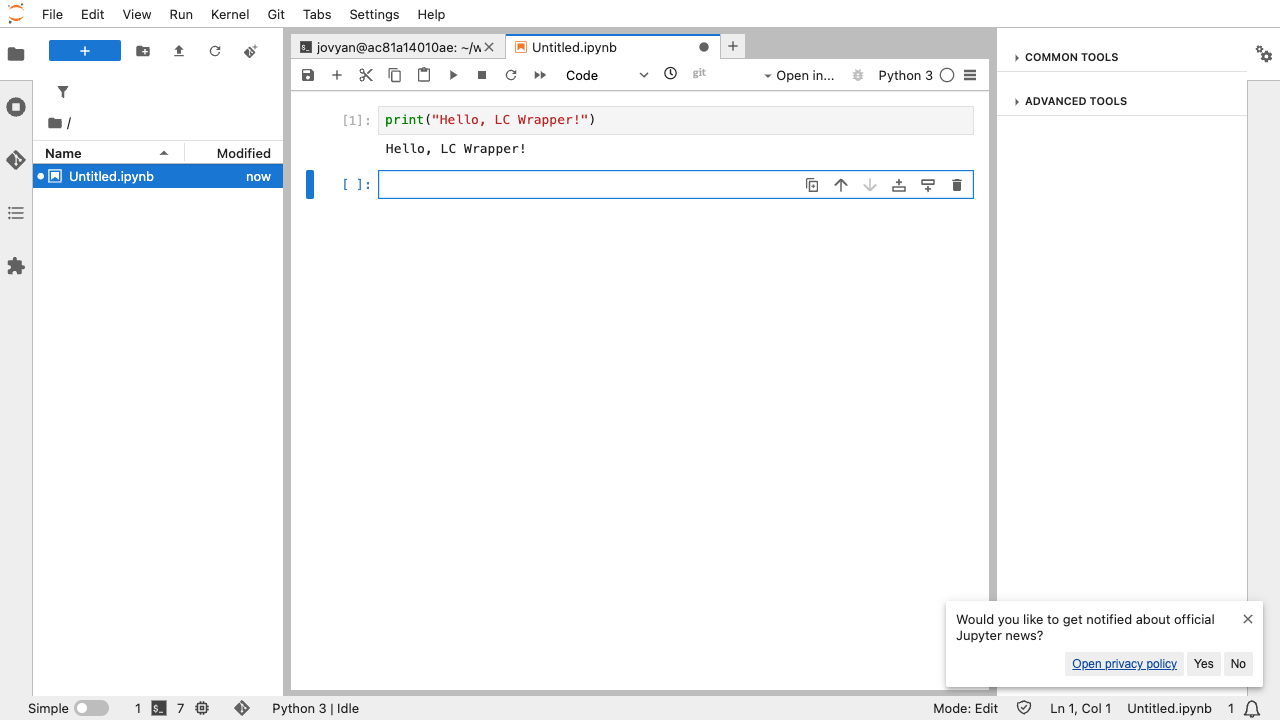

In [140]:
async def _step(page):
    panel = page.locator(f'#{created_panel_id}')
    # Get the first cell's editor
    cell = panel.locator('.jp-Cell-inputArea .cm-content').first
    
    # Enter code
    await cell.click()
    await cell.type('print("Hello, LC Wrapper!")', delay=50)
    
    # Execute with Shift+Enter
    await page.keyboard.press('Shift+Enter')
    
    # Wait for execution to complete
    await asyncio.sleep(2)
    
    # Verify output in the first cell
    first_cell = panel.locator('.jp-Cell').nth(0)
    output = first_cell.locator('.jp-OutputArea-output')
    await expect(output).to_contain_text('Hello, LC Wrapper!', timeout=transition_timeout)
    
    print("Basic code executed successfully")

await run_pw(_step)

## Save the notebook

Start epoch: 1762821585.257789 seconds


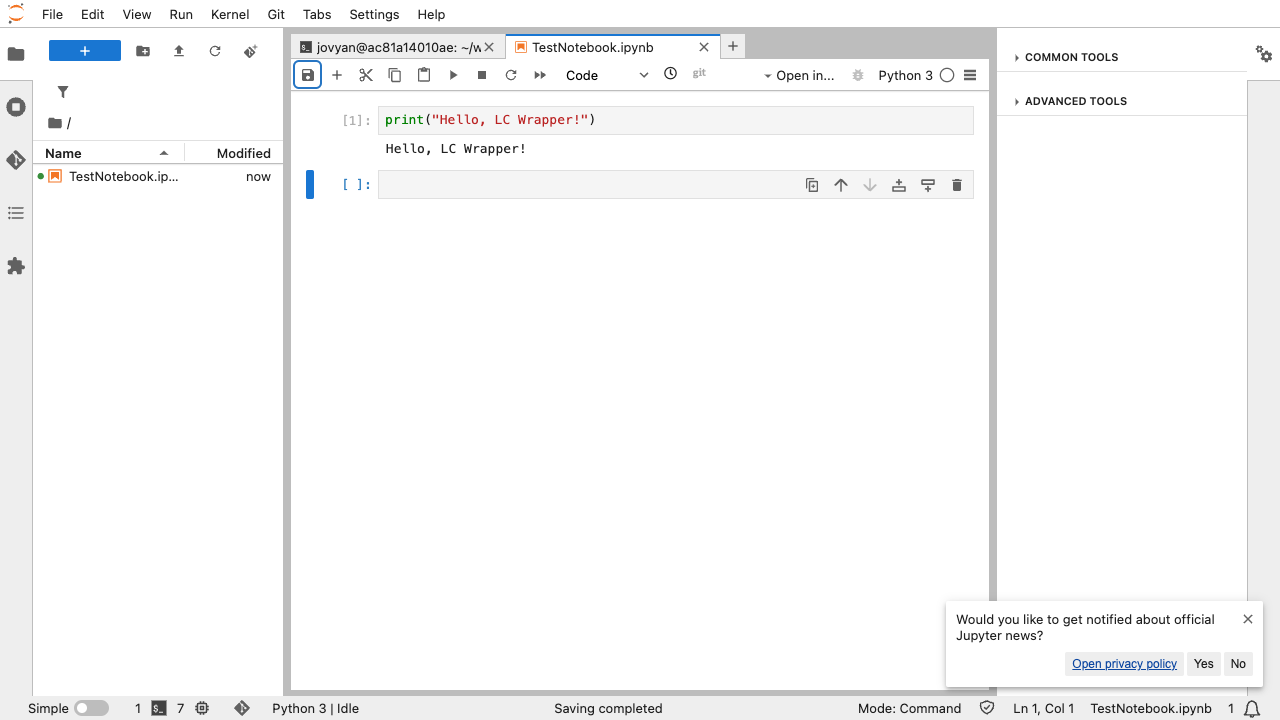

In [141]:
async def _step(page):
    await page.locator('//*[@data-command="docmanager:save"]').click()

    await page.locator('//*[contains(@class, "jp-Dialog-header") and text()="Rename file"]/..//input[@placeholder="File name"]').fill(test_filename)

    await page.locator('//*[contains(@class, "jp-Dialog-buttonLabel") and text()="Rename and Save"]').click()

    await expect(lc_wrapper.get_file_browser_item_locator(page, test_filename)).to_be_visible(timeout=transition_timeout * 3)

await run_pw(_step)

## Verify that log_history metadata is recorded

Start epoch: 1762821585.7291079 seconds
Cell metadata: {'lc_cell_meme': {'current': 'e8fb6028-be96-11f0-b921-069e2863921c', 'execution_end_time': '2025-11-11T00:39:42.991Z', 'next': 'ea125e94-be96-11f0-b921-069e2863921c'}, 'lc_wrapper': {'last_execution': {'lc_current_cell_meme': 'e8fb6028-be96-11f0-b921-069e2863921c', 'lc_current_notebook_meme': 'e8fb5f1a-be96-11f0-b921-069e2863921c', 'notebook_path': 'Untitled.ipynb'}, 'log_history': ['/home/jovyan/work/.log/20251111/20251111-003942-0958.log']}}
Log path recorded: /home/jovyan/work/.log/20251111/20251111-003942-0958.log
Metadata verification passed!


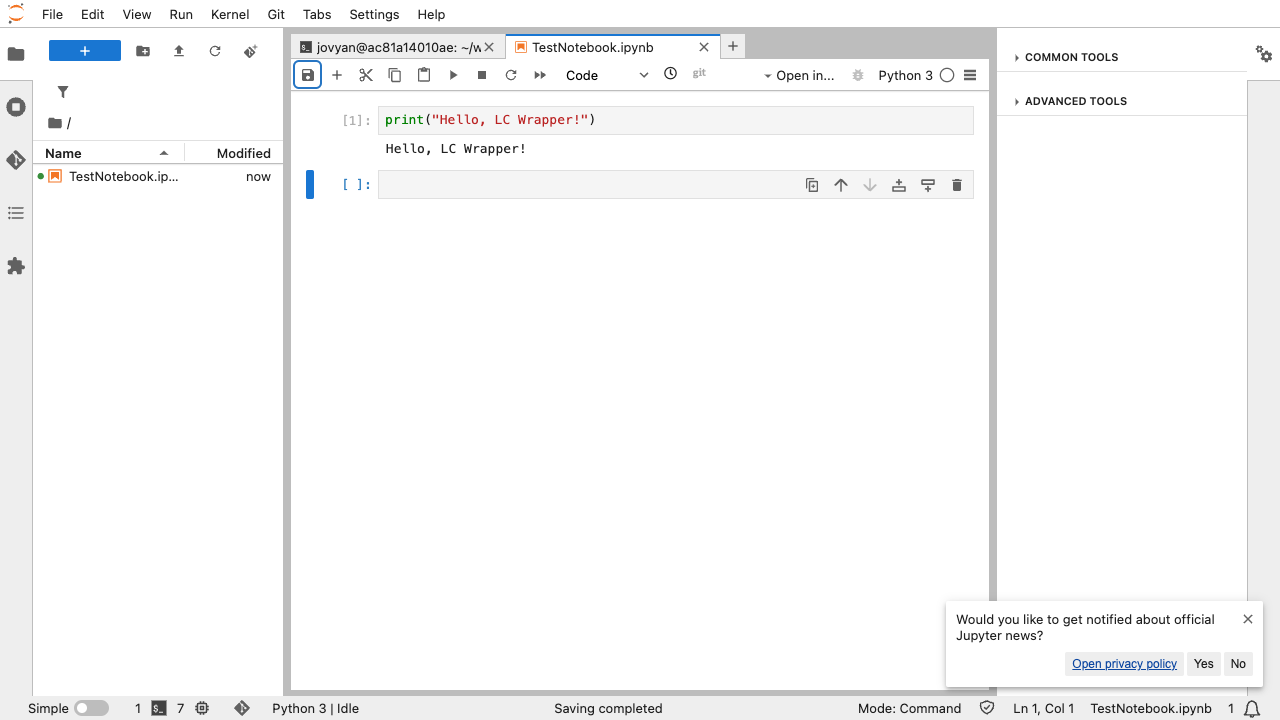

In [142]:
import json
from pathlib import Path

first_log_path = None

async def _step(page):
    assert jupyter_work_dir is not None, "jupyter_work_dir must be set to verify metadata"

    notebook_path = Path(jupyter_work_dir) / test_filename
    assert notebook_path.exists(), f"Notebook file not found: {notebook_path}"

    with open(notebook_path, 'r') as f:
        notebook_data = json.load(f)

    cells = notebook_data['cells']
    assert len(cells) > 0, "No cells found in notebook"

    first_cell = cells[0]
    metadata = first_cell.get('metadata', {})

    print(f"Cell metadata: {metadata}")

    assert 'lc_wrapper' in metadata, "lc_wrapper metadata not found"
    assert 'log_history' in metadata['lc_wrapper'], "log_history not found in lc_wrapper metadata"
    assert len(metadata['lc_wrapper']['log_history']) == 1, f"Expected 1 log entry, got {len(metadata['lc_wrapper']['log_history'])}"

    global first_log_path
    first_log_path = metadata['lc_wrapper']['log_history'][0]

    print(f"Log path recorded: {first_log_path}")
    print("Metadata verification passed!")

await run_pw(_step)

## Verify that log file was created

Start epoch: 1762821586.016384 seconds
Log file verified: ../artifacts/jupyter-work/.log/20251111/20251111-003942-0958.log
Log file content verified: contains code, metadata, and output
JSON metadata file verified: ../artifacts/jupyter-work/.log/e8fb6028-be96-11f0-b921-069e2863921c/e8fb6028-be96-11f0-b921-069e2863921c.json
JSON structure verified: 1 entries with all required fields
First entry: code=print("Hello, LC Wrapper!")..., status=ok


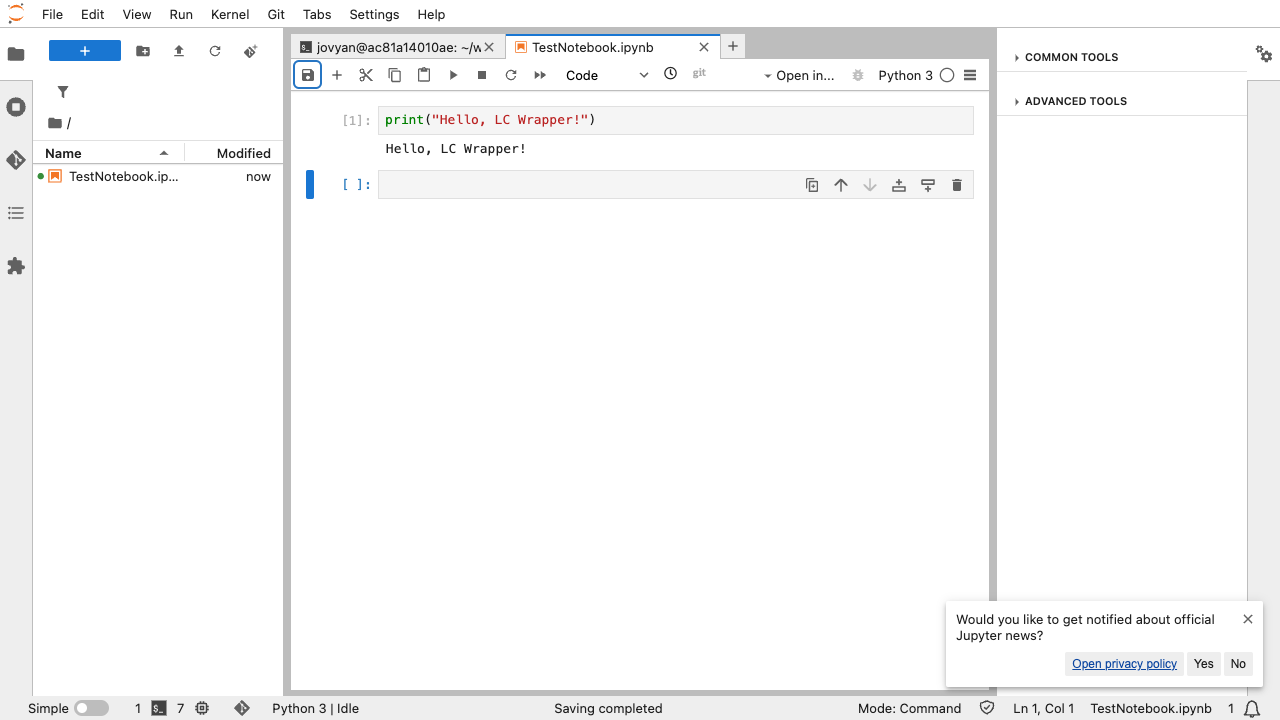

In [143]:
import json
from pathlib import Path

async def _step(page):
    assert jupyter_work_dir is not None, "jupyter_work_dir must be set"
    
    notebook_path = Path(jupyter_work_dir) / test_filename
    with open(notebook_path, 'r') as f:
        notebook_data = json.load(f)
    
    first_cell = notebook_data['cells'][0]
    cell_metadata = first_cell['metadata']
    log_path = cell_metadata['lc_wrapper']['log_history'][0]
    
    # Get cell source as string
    cell_source = ''.join(first_cell['source']) if isinstance(first_cell['source'], list) else first_cell['source']
    
    # Verify .log file exists
    relative_path = log_path.replace('/home/jovyan/work/', '')
    host_log_path = Path(jupyter_work_dir) / relative_path
    assert host_log_path.exists(), f"Log file not found: {host_log_path}"
    print(f"Log file verified: {host_log_path}")
    
    # Read and verify .log file content
    with open(host_log_path, 'r') as f:
        log_content = f.read()
    
    # Verify log contains expected sections
    assert '----' in log_content, "Log file should contain '----' separators"
    assert cell_source in log_content, f"Log file should contain executed code: {cell_source}"
    assert 'start time:' in log_content, "Log file should contain 'start time:'"
    assert 'end time:' in log_content, "Log file should contain 'end time:'"
    assert 'execute_reply_status:' in log_content, "Log file should contain 'execute_reply_status:'"
    assert f"path: {log_path}" in log_content, f"Log file should contain path: {log_path}"
    assert 'notebook_path:' in log_content, "Log file should contain notebook_path:"
    
    # Verify output is in log file
    expected_output = "Hello, LC Wrapper!"
    assert expected_output in log_content, f"Log file should contain output: {expected_output}"
    
    print(f"Log file content verified: contains code, metadata, and output")
    
    # Verify JSON metadata file exists
    lc_cell_meme = cell_metadata['lc_cell_meme']['current']
    json_file_path = Path(jupyter_work_dir) / '.log' / lc_cell_meme / f'{lc_cell_meme}.json'
    assert json_file_path.exists(), f"JSON metadata file not found: {json_file_path}"
    print(f"JSON metadata file verified: {json_file_path}")
    
    # Parse and verify JSON structure
    with open(json_file_path, 'r') as f:
        json_data = json.load(f)
    
    assert isinstance(json_data, list), f"JSON data should be a list, got {type(json_data)}"
    assert len(json_data) == len(cell_metadata['lc_wrapper']['log_history']), \
        f"JSON entries count ({len(json_data)}) should match log_history count ({len(cell_metadata['lc_wrapper']['log_history'])})"
    
    # Verify first entry structure and content
    first_entry = json_data[0]
    required_fields = ['code', 'path', 'start', 'end', 'size', 'notebook_path', 
                       'lc_notebook_meme', 'execute_reply_status']
    for field in required_fields:
        assert field in first_entry, f"Required field '{field}' not found in JSON entry"
    
    assert first_entry['code'] == cell_source, \
        f"Code in JSON ({first_entry['code']}) doesn't match cell source ({cell_source})"
    assert first_entry['path'] == log_path, \
        f"Path in JSON ({first_entry['path']}) doesn't match log_history ({log_path})"
    assert first_entry['execute_reply_status'] == 'ok', \
        f"execute_reply_status should be 'ok', got '{first_entry['execute_reply_status']}'"
    
    print(f"JSON structure verified: {len(json_data)} entries with all required fields")
    print(f"First entry: code={first_entry['code'][:30]}..., status={first_entry['execute_reply_status']}")

await run_pw(_step)

## Re-execute the cell and verify log_history grows

Start epoch: 1762821586.2969542 seconds
Cell metadata after re-execution: {'lc_cell_meme': {'current': 'e8fb6028-be96-11f0-b921-069e2863921c', 'execution_end_time': '2025-11-11T00:39:46.450Z', 'next': 'ea125e94-be96-11f0-b921-069e2863921c'}, 'lc_wrapper': {'last_execution': {'lc_current_cell_meme': 'e8fb6028-be96-11f0-b921-069e2863921c', 'lc_current_notebook_meme': 'e8fb5f1a-be96-11f0-b921-069e2863921c', 'notebook_path': 'TestNotebook.ipynb'}, 'log_history': ['/home/jovyan/work/.log/20251111/20251111-003942-0958.log', '/home/jovyan/work/.log/20251111/20251111-003946-0410.log']}}
Re-execution test passed! log_history now has 2 entries
Second log file verified: ../artifacts/jupyter-work/.log/20251111/20251111-003946-0410.log
JSON verified: 2 entries, second entry has correct structure and content


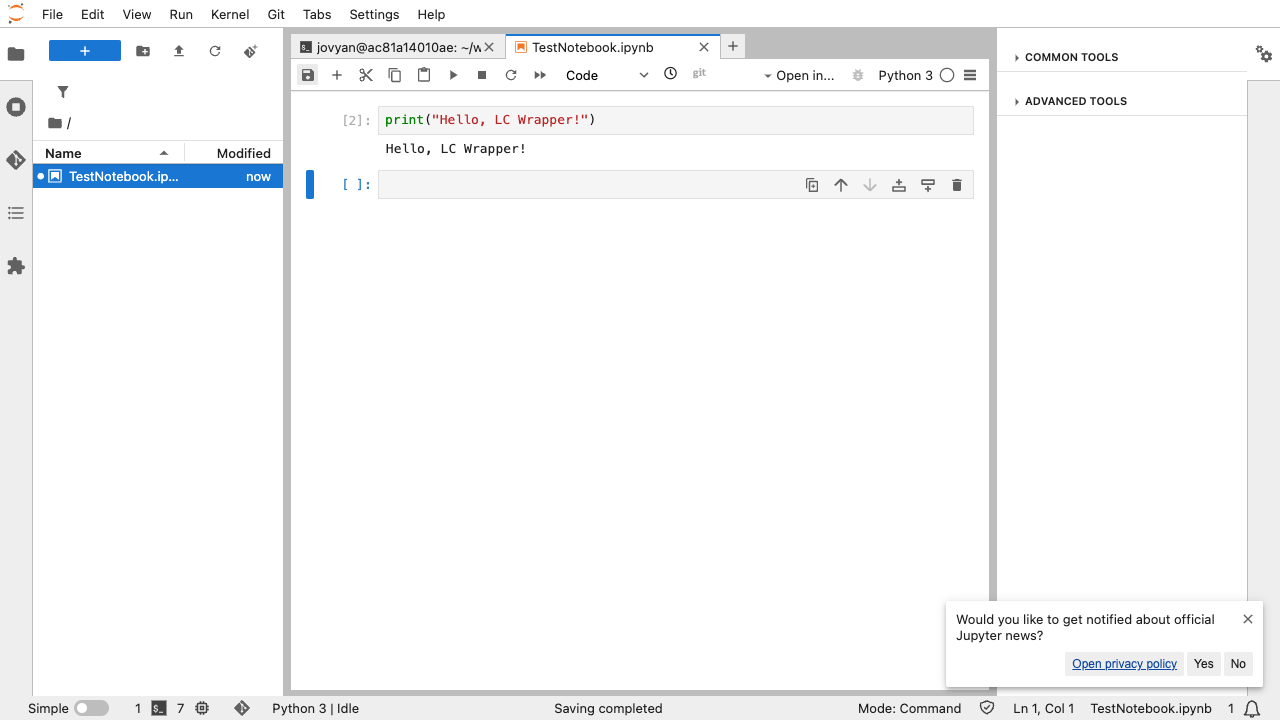

In [144]:
import json
from pathlib import Path

async def _step(page):
    panel = page.locator(f'#{created_panel_id}')
    # Get the first cell explicitly using nth(0)
    cell = panel.locator('.jp-Cell').nth(0)
    
    # Click on the cell
    await cell.click()
    
    # Execute with Shift+Enter
    await page.keyboard.press('Shift+Enter')
    
    # Wait for execution to complete
    await asyncio.sleep(2)
    
    # Save the notebook
    await page.locator('//*[@data-command="docmanager:save"]').click()
    await asyncio.sleep(1)
    
    # Read notebook file and check metadata
    notebook_path = Path(jupyter_work_dir) / test_filename
    with open(notebook_path, 'r') as f:
        notebook_data = json.load(f)
    
    first_cell = notebook_data['cells'][0]
    cell_metadata = first_cell.get('metadata', {})
    
    print(f"Cell metadata after re-execution: {cell_metadata}")
    
    assert 'lc_wrapper' in cell_metadata, "lc_wrapper metadata not found"
    assert 'log_history' in cell_metadata['lc_wrapper'], "log_history not found"
    assert len(cell_metadata['lc_wrapper']['log_history']) == 2, \
        f"Expected 2 log entries, got {len(cell_metadata['lc_wrapper']['log_history'])}"
    
    print("Re-execution test passed! log_history now has 2 entries")
    
    # Get cell source as string
    cell_source = ''.join(first_cell['source']) if isinstance(first_cell['source'], list) else first_cell['source']
    
    # Verify second log file exists and has correct content
    second_log_path = cell_metadata['lc_wrapper']['log_history'][1]
    relative_path = second_log_path.replace('/home/jovyan/work/', '')
    host_log_path = Path(jupyter_work_dir) / relative_path
    assert host_log_path.exists(), f"Second log file not found: {host_log_path}"
    
    # Read and verify second log file content
    with open(host_log_path, 'r') as f:
        log_content = f.read()
    
    assert '----' in log_content, "Second log file should contain '----' separators"
    assert cell_source in log_content, f"Second log file should contain executed code"
    assert 'start time:' in log_content, "Second log file should contain 'start time:'"
    assert 'end time:' in log_content, "Second log file should contain 'end time:'"
    assert 'execute_reply_status:' in log_content, "Second log file should contain 'execute_reply_status:'"
    assert f"path: {second_log_path}" in log_content, f"Second log file should contain its path"
    
    expected_output = "Hello, LC Wrapper!"
    assert expected_output in log_content, f"Second log file should contain output: {expected_output}"
    
    print(f"Second log file verified: {host_log_path}")
    
    # Verify JSON metadata file has 2 entries
    lc_cell_meme = cell_metadata['lc_cell_meme']['current']
    json_file_path = Path(jupyter_work_dir) / '.log' / lc_cell_meme / f'{lc_cell_meme}.json'
    
    with open(json_file_path, 'r') as f:
        json_data = json.load(f)
    
    assert len(json_data) == 2, f"JSON should have 2 entries, got {len(json_data)}"
    
    # Verify second entry structure and content
    second_entry = json_data[1]
    required_fields = ['code', 'path', 'start', 'end', 'size', 'notebook_path', 
                       'lc_notebook_meme', 'execute_reply_status']
    for field in required_fields:
        assert field in second_entry, f"Required field '{field}' not found in second JSON entry"
    
    assert second_entry['code'] == cell_source, \
        f"Code in second JSON entry doesn't match cell source"
    assert second_entry['path'] == second_log_path, \
        f"Path in second JSON entry doesn't match log_history"
    assert second_entry['notebook_path'] == test_filename, \
        f"notebook_path in second JSON entry should be {test_filename}, got {second_entry['notebook_path']}"
    assert second_entry['execute_reply_status'] == 'ok', \
        f"execute_reply_status should be 'ok', got '{second_entry['execute_reply_status']}'"
    
    print(f"JSON verified: 2 entries, second entry has correct structure and content")

await run_pw(_step)

## Test summarize mode with !! command

Start epoch: 1762821589.726041 seconds
Current cell count: 2
Summarize output: path: /home/jovyan/work/.log/20251111/20251111-003952-0118.log (1 logs recorded)
start time: 2025-11-11 00:39:52(UTC)
end time: 2025-11-11 00:39:52(UTC)
output size: 790 bytes
0 chunks with matched ke...
Output has 47 lines
Summarize mode test passed!


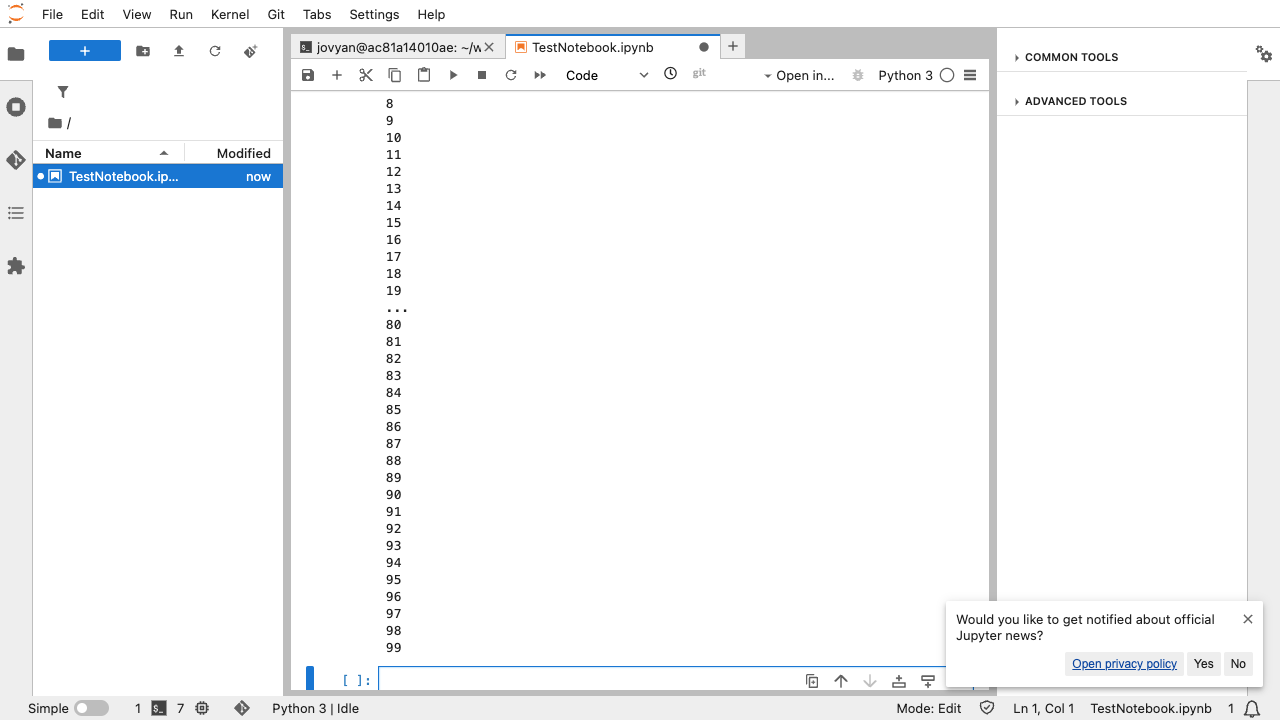

In [145]:
async def _step(page):
    panel = page.locator(f'#{created_panel_id}')
    
    # Get the second cell (should be created after Shift+Enter)
    await asyncio.sleep(0.5)
    cells = panel.locator('.jp-Cell')
    cell_count = await cells.count()
    
    print(f"Current cell count: {cell_count}")
    
    # Get the last cell
    cell = cells.nth(cell_count - 1)
    editor = cell.locator('.cm-content')
    
    # Enter summarize mode code
    await editor.click()
    await editor.type('!!for i in range(100):\n    print(i)', delay=50)
    
    # Execute
    await page.keyboard.press('Shift+Enter')
    
    # Wait for execution
    await asyncio.sleep(3)
    
    # Get output text
    output = cell.locator('.jp-OutputArea-output')
    output_text = await output.inner_text()
    
    print(f"Summarize output: {output_text[:200]}...")
    
    # Verify summarize mode worked
    assert 'start time:' in output_text.lower() or 'start:' in output_text.lower(), "Start time not found in output"
    assert 'end time:' in output_text.lower() or 'end:' in output_text.lower(), "End time not found in output"
    assert 'path:' in output_text.lower() or '.log' in output_text, "Log path not found in output"
    
    # Verify output is summarized (not all 100 lines)
    lines = output_text.split('\n')
    print(f"Output has {len(lines)} lines")
    assert len(lines) < 100, f"Output should be summarized, but has {len(lines)} lines"
    
    print("Summarize mode test passed!")

await run_pw(_step)

## Clean up

In [ ]:
await finish_pw_context()

In [147]:
!rm -fr {work_dir}